# BiGAN Implementation

    by: Udaikaran Singh
    date started: 7/22/2019
    reference: https://arxiv.org/pdf/1605.09782.pdf
    data: https://sites.google.com/view/11khands

In [1]:
import numpy as np
import torch as torch
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import random
import os
import itertools

In [2]:
data_path = os.getcwd() + "/data/Hands/"

In [3]:
img1 = data_path + 'Hand_0000006.jpg'

In [4]:
img1_pic = plt.imread(img1)

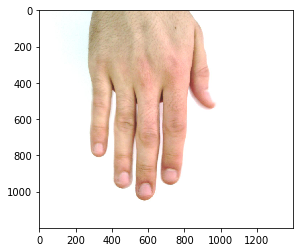

In [5]:
plt.imshow(img1_pic[0:1200,200:])

## Model

In [6]:
from bigan import Generator, Discriminator, Encoder

### Hyperparemeters Set 1

In [7]:
cuda_available = torch.cuda.is_available()
latent_size = 100
batch_size = 16
drouput_p = 0.2

In [8]:
if cuda_available:
    print("Using GPU")
else:
    print("Using CPU")

Using CPU


In [11]:
if cuda_available:
    generator = Generator(latent_size= latent_size).cuda()
    discriminator = Discriminator(latent_size= latent_size,
                              dropout= drouput_p, 
                              output_size= 1).cuda()
    encoder = Encoder(latent_size= latent_size).cuda()
else:
    generator = Generator(latent_size= latent_size)
    discriminator = Discriminator(latent_size= latent_size,
                              dropout= drouput_p, 
                              output_size= 1)
    encoder = Encoder(latent_size= latent_size)

if os.path.exists("discriminator_model.pth"):
    genload = torch.load('generator_model.pth', map_location='cpu')
    discrimload = torch.load('discriminator_model.pth', map_location='cpu')
    encodload = torch.load("encoder_model.pth", map_location='cpu')
    
    generator.load_state_dict(genload)
    discriminator.load_state_dict(discrimload)
    encoder.load_state_dict(encodload)

In [12]:
z_random = Variable(torch.randn(batch_size, latent_size, 1, 1).type(torch.FloatTensor))

In [14]:
imgs = generator(z_random)

## Preproccessing

In [11]:
transform = transforms.Compose([transforms.CenterCrop((1200, 1200)),
                                transforms.Resize((64,64)),
                                transforms.ToTensor(),
                                transforms.Normalize((0,0,0), (0.5, 0.5, 0.5))])

## Training

In [12]:
random.seed(1)

    Hyperparameters Set 2

In [13]:
learning_rate = 0.2e-4
beta1 = 0.5
beta2 = 0.999
num_epochs = 50

In [14]:
epsilon = 1e-8

In [15]:
optimizer_d = optim.Adam(discriminator.parameters(), 
                         lr=learning_rate, 
                         betas=(beta1, beta2))
optimizer_pq = optim.Adam(itertools.chain(generator.parameters(), encoder.parameters()), 
                          lr=learning_rate, 
                          betas=(beta1, beta2))

In [16]:
training_data = ImageFolder(os.getcwd() + "/data/", transform = transform)
data_loader = torch.utils.data.DataLoader(training_data,
                                          batch_size= batch_size,
                                          shuffle=True,
                                          num_workers= 1)

In [18]:
discriminator_loss = []
generator_loss = []
for epoch in range(num_epochs):
    
    print("epoch: " + str(epoch + 1))
    
    generated_image = 0
    for step, (images, _) in enumerate(data_loader, 0):
        
        if (images.shape[0] != batch_size):
            if cuda_available:
                z_random = Variable(torch.randn(batch_size, latent_size, 1, 1).type(torch.cuda.FloatTensor)) #latent space sample
            else:
                z_random = Variable(torch.randn(batch_size, latent_size, 1, 1).type(torch.FloatTensor))
            
            generated_image = generator(z_random)[0]
        else:
            discriminator.zero_grad()
            encoder.zero_grad()
            generator.zero_grad()

            if cuda_available:
                z_random = Variable(torch.randn(batch_size, latent_size, 1, 1).type(torch.cuda.FloatTensor)) #latent space sample
                x_real = Variable(images.type(torch.cuda.FloatTensor)) #real images
            else:
                z_random = Variable(torch.randn(batch_size, latent_size, 1, 1).type(torch.FloatTensor))
                x_real = Variable(images.type(torch.FloatTensor))

            #data generation
            x_hat = generator(z_random) #generated images 
            #output size: (batch size x 3 x 64 x 64)
            z_hat = encoder(x_real) #mapping from images back to latent space
            #output size: (batch size x latent space x 1 x 1)



            #discriminator step
            z_output = discriminator(x_real, z_hat) 
            x_output = discriminator(x_hat, z_random)

            #finding loss
            loss_d = -torch.mean(torch.log(z_output + epsilon) + torch.log(1-x_output + epsilon))
            loss_pq = -torch.mean(torch.log(x_output + epsilon) + torch.log(1-z_output + epsilon))

            discriminator_loss.append(loss_d.item())
            generator_loss.append(loss_d.item())

            #backpropagation
            loss_d.backward(retain_graph = True)
            optimizer_d.step()
            loss_pq.backward()
            optimizer_pq.step()
    
    path = "generator_model.pth"
    torch.save(generator.state_dict(), path)
    path = "encoder_model.pth"
    torch.save(encoder.state_dict(), path)
    path = "discriminator_model.pth"
    torch.save(discriminator.state_dict(), path)
    
    plt.imshow(generated_image)
        
        
        

epoch: 1


KeyboardInterrupt: 

## Evaluation

Goal:
    - evaluate the feature learned along each axis of the latent space.
    - idea: the features learned by the generator will lie along a linear subspace of the latent space
        - example 1: the color of the skin may be a variable along a certain axis of the latent space.
        - example 2: the age (approximated by how many wrinkles on the hand) may be along another 
        axis of the latent space.
        
        
    - procedure:
        - use the encoder to relate each image to values in the latent space (z variable).
        - sort along a certain axis

In [17]:
eval_data_loader = torch.utils.data.DataLoader(training_data,
                                               batch_size= 1,
                                               num_workers= 1)

In [18]:
output = []
for step, (images, _) in enumerate(eval_data_loader, 0):
    
    images = images.type(torch.cuda.FloatTensor)
    z_pred = encoder(images).cpu().detach().numpy()[0,:,0,0]
    address = eval_data_loader.dataset.imgs[step][0]
    
    output.append((z_pred, address))

In [19]:
latent_axis = 0

In [20]:
output_sorted = sorted(output, key=lambda x:x[0][latent_axis])